In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding="valid")
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="valid")
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding="valid")
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        exit_outputs = []
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        exit_outputs.append(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        exit_outputs.append(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        exit_outputs.append(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x, exit_outputs

In [4]:
# class IndividualEEModel(nn.Module):
#     def __init__(self, in_features):
#         super(IndividualEEModel, self).__init__()
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(in_features=in_features, out_features=10)
    
#     def forward(self, x):
#         x = self.pool(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         return x

In [5]:
class IndividualEEModel(nn.Module):
    def __init__(self, in_features):
        super(IndividualEEModel, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [6]:
# class GeneralEEModel(nn.Module):
#     def __init__(self):
#         super(GeneralEEModel, self).__init__()
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         self.pool1 = nn.MaxPool1d(kernel_size=3, stride=3)
#         self.fc1 = nn.Linear(in_features=14400, out_features=32)
#         self.fc2 = nn.Linear(in_features=25088, out_features=32)
#         self.fc3 = nn.Linear(in_features=10816, out_features=32)
#         self.fcs = [self.fc1, self.fc2, self.fc3]
#         self.flatten = nn.Flatten()
#         self.fc4 = nn.Linear(in_features=32, out_features=10)
    
#     def forward(self, x):
#         fc_outs = []
#         batch_size = x[0].shape[0]
#         for i, x_ in enumerate(x):
#             x_ = self.pool(x_)
#             x_ = self.flatten(x_)
#             x_ = self.fcs[i](x_)
#             x_ = F.relu(x_)
#             fc_outs.append(x_)
#         xx = []
#         for i in range(32):
#             for j in range(len(fc_outs)):
#                 xx.append(torch.reshape(fc_outs[j][:, i], (batch_size, 1)))
#         x = torch.cat(xx, dim=1)
#         x = torch.unsqueeze(x, 1)
#         x = self.pool1(x)
#         x = self.flatten(x)
#         x = self.fc4(x)
#         return x

In [7]:
class GeneralEEModel(nn.Module):
    def __init__(self):
        super(GeneralEEModel, self).__init__()
        self.pool_kernels = [
            (1, 6, 6), (1, 3, 3), (1, 1, 1)
        ]
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(in_features=1024, out_features=10)
    
    def forward(self, x, inference=False):
        pooled_outs = []
        for layer, out in enumerate(x):
            pool_3d = nn.MaxPool3d(kernel_size=self.pool_kernels[layer])
            pooled_outs.append(pool_3d(out))
        x = torch.cat(pooled_outs, dim=1)
        x = self.flatten(x)
        x = self.dropout(x)
        scores = self.fc(x)
        return scores

In [8]:
def simulate_exit(x, choice=None):
    if choice is not None:
        choice = choice
    else:
        choice = np.random.choice(np.arange(0, 3), p=[0.34, 0.33, 0.33])
    batch_size = x[0].shape[0]
    reshaped_output = []
    for i in range(3):
        if i <= choice :
            reshaped_output.append(x[i])
        else:
            reshaped_output.append(torch.zeros_like(x[i]))
    return reshaped_output, choice

In [9]:
def train(baseline, exit_model, layer, epochs, criterion, 
          optimizer, train_loader, val_loader, model_name, gen_ee=False):
    best_val_epoch, best_val_loss = 0, 1e6
    break_flag = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
        exit_model.train()
        t_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            t_loss += loss.item()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        t_loss = t_loss / (i+1)
        t_loss = round(t_loss, 5)
        t_acc = round(100*(correct / total), 5)
        exit_model.eval()
        v_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        v_loss = v_loss/(i+1)
        v_loss = round(v_loss, 5)
        v_acc = round(100*(correct / total), 5)
        if v_loss <= best_val_loss:
            torch.save(exit_model.state_dict(), model_name)
            best_val_epoch = epoch + 1
            best_val_loss = v_loss
            break_flag = 0
        else:
            break_flag += 1
        print(f'Epoch[{epoch+1}]: t_loss: {t_loss} t_acc: {t_acc} v_loss: {v_loss} v_acc: {v_acc}')
        if break_flag >19 :
            break
    print('Finished Training')
    print('Best model saved at epoch: ', best_val_epoch)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
dataset = CIFAR10(root='./data', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='./data', train=False, transform=ToTensor())

Files already downloaded and verified


In [12]:
batch_size=128
val_size = 5000
pct = .01
train_size = int(pct*len(dataset))
val_size = len(dataset) - train_size
# train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
_, val_ds = random_split(val_ds, [int(0.7*len(val_ds)), len(val_ds) - int(0.7*len(val_ds))])
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4)

In [13]:
baseline = Baseline().to(device)
baseline.load_state_dict(torch.load("cifar10_baseline_s_new_compressed.h5", map_location='cpu'))
ee_model_name = "cifar10_ee_s.h5"
baseline.eval()

Baseline(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [14]:
# in_features = []
# m = nn.MaxPool2d(kernel_size=2)
# f = nn.Flatten()
# _, outs = baseline(torch.randn(2, 3, 32, 32).to(device))
# for out in outs:
#     print(out.shape)
#     xx = f(m(out))
#     in_features.append(xx.shape[1])

In [15]:
# intermediate_outputs = []
# pool_kernels = [(1, 6, 6), (1, 3, 3), (1, 1, 1)]
# f = nn.Flatten()
# _, outs = baseline(torch.randn(2, 3, 32, 32).to(device))
# for i, out in enumerate(outs):
#     m = nn.MaxPool3d(kernel_size=pool_kernels[i])
#     xx = m(out)
#     intermediate_outputs.append(xx)
#     print(out.shape, xx.shape)
# xx = torch.cat(intermediate_outputs, dim=1)
# print(xx.shape)
# xx = f(xx)
# print(xx.shape)

In [16]:
# result_dict = {}
# result_dict["accuracy"] = []
# for ii, in_feature in enumerate(in_features):
#     print(f'Training for exit layer: {ii+1}')
#     precisions, recall, f1 = [], [], []
#     learning_rate = 1e-3
#     exit_model = IndividualEEModel(in_features=in_feature).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(exit_model.parameters(), lr=1e-3, momentum=0.9)
#     epochs = 100
#     ee_model_name = "ind_ee_cifar10_s_conv.h5"
#     train(baseline, exit_model, ii, epochs, criterion, optimizer, train_loader, val_loader, ee_model_name)
#     exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
#     exit_model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad(): 
#         true_y, pred_y = [], []
#         for i, data in enumerate(test_loader):
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             _, outs = baseline(images)
#             outputs = exit_model(outs[ii])
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             pred_y = pred_y + list(predicted.detach().cpu().numpy())
#             true_y = true_y + list(labels.detach().cpu().numpy())
#         report = classification_report(true_y, pred_y, output_dict=True)
#         result_dict["accuracy"].append(report["accuracy"])
#         for i, (key, value) in enumerate(report.items()):
#             if i < 10:
#                 precisions.append(value['precision'])
#                 recall.append(value['recall'])
#                 f1.append(value['f1-score'])
#         result_dict[ii] = {
#             'precision': precisions,
#             'recall': recall,
#             'f1': f1,
#             'conf_mat': confusion_matrix(true_y, pred_y)
#         }

In [ ]:
# fig, axes = plt.subplots(len(in_features), 1, figsize=(15, 9))
# class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# axes = axes.ravel()
# bar_width = 0.25
# for i, ax in enumerate(axes):
#     precisions = result_dict[i]['precision']
#     recall = result_dict[i]['recall']
#     f1 = result_dict[i]['f1']
#     r1 = np.arange(len(precisions))
#     r2 = [x + bar_width for x in r1]
#     r3 = [x + bar_width for x in r2]
#     ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
#     ax.bar(r2, recall, color='green', width=bar_width, edgecolor#         x = self.fc1(x)='white', label='Recall')
#     ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
#     ax.set_title(str(i))
#     ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
#     ax.grid()
# plt.xlabel('Class', fontweight='bold')
# lines_labels = [ax.get_legend_handles_labels()]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
# plt.tight_layout(pad=3)
# plt.show()

'fontsize=18)'

In [18]:
# ind_accuracies = []
# for i, accuracy in enumerate(result_dict['accuracy']):
#     accuracy = round(accuracy, 4)
#     precision = round(np.mean(result_dict[i]["precision"]), 4)
#     recall = round(np.mean(result_dict[i]["recall"]), 4)
#     f1 = round(np.mean(result_dict[i]["f1"]), 4)
#     ind_accuracies.append(accuracy)
#     print(f'Layer {i+1}: Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | f1-score: {f1}')    

In [19]:
result_dict = {}
result_dict["accuracy"] = []
in_features = [0]
for ii, in_feature in enumerate(in_features):
    precisions, recall, f1 = [], [], []
    learning_rate = 5e-3
    exit_model = GeneralEEModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(exit_model.parameters(), lr=learning_rate, momentum=0.9)
    epochs = 100
    ee_model_name = "gen_ee_cifar10_s_new.h5"
    train(baseline, exit_model, ii, epochs, criterion, optimizer, 
          train_loader, val_loader, ee_model_name, gen_ee=True)
    exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
    exit_model.eval()
    correct = 0
    total = 0#         x = self.fc1(x)
    with torch.no_grad(): 
        true_y, pred_y = [], []
        for i, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            outs, _ = simulate_exit(outs)
            outputs = exit_model(outs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_y = pred_y + list(predicted.detach().cpu().numpy())
            true_y = true_y + list(labels.detach().cpu().numpy())
        report = classification_report(true_y, pred_y, output_dict=True)
        result_dict["accuracy"].append(report["accuracy"])
        for i, (key, value) in enumerate(report.items()):
            if i < 10:
                precisions.append(value['precision'])
                recall.append(value['recall'])
                f1.append(value['f1-score'])
        result_dict[ii] = {
            'precision': precisions,
            'recall': recall,
            'f1': f1,
            'conf_mat': confusion_matrix(true_y, pred_y)
        }

Epoch[1]: t_loss: 2.29938 t_acc: 10.2 v_loss: 2.28244 v_acc: 11.85185
Epoch[2]: t_loss: 2.25066 t_acc: 16.2 v_loss: 2.266 v_acc: 15.20539
Epoch[3]: t_loss: 2.21014 t_acc: 16.8 v_loss: 2.25379 v_acc: 16.27609
Epoch[4]: t_loss: 2.1839 t_acc: 19.0 v_loss: 2.22773 v_acc: 19.47475
Epoch[5]: t_loss: 2.13628 t_acc: 24.2 v_loss: 2.17111 v_acc: 24.34343
Epoch[6]: t_loss: 2.10475 t_acc: 25.0 v_loss: 2.12348 v_acc: 26.74747
Epoch[7]: t_loss: 2.12808 t_acc: 26.6 v_loss: 2.09619 v_acc: 27.37374
Epoch[8]: t_loss: 1.93904 t_acc: 36.8 v_loss: 2.04194 v_acc: 29.00337
Epoch[9]: t_loss: 1.97869 t_acc: 32.4 v_loss: 2.03887 v_acc: 28.76768
Epoch[10]: t_loss: 2.10544 t_acc: 24.8 v_loss: 2.06343 v_acc: 27.46801
Epoch[11]: t_loss: 1.91586 t_acc: 34.8 v_loss: 2.04554 v_acc: 28.96296
Epoch[12]: t_loss: 1.92376 t_acc: 34.0 v_loss: 2.01928 v_acc: 30.84175
Epoch[13]: t_loss: 1.95034 t_acc: 33.0 v_loss: 1.93176 v_acc: 35.65657
Epoch[14]: t_loss: 1.7526 t_acc: 43.8 v_loss: 1.93636 v_acc: 35.75084
Epoch[15]: t_loss: 

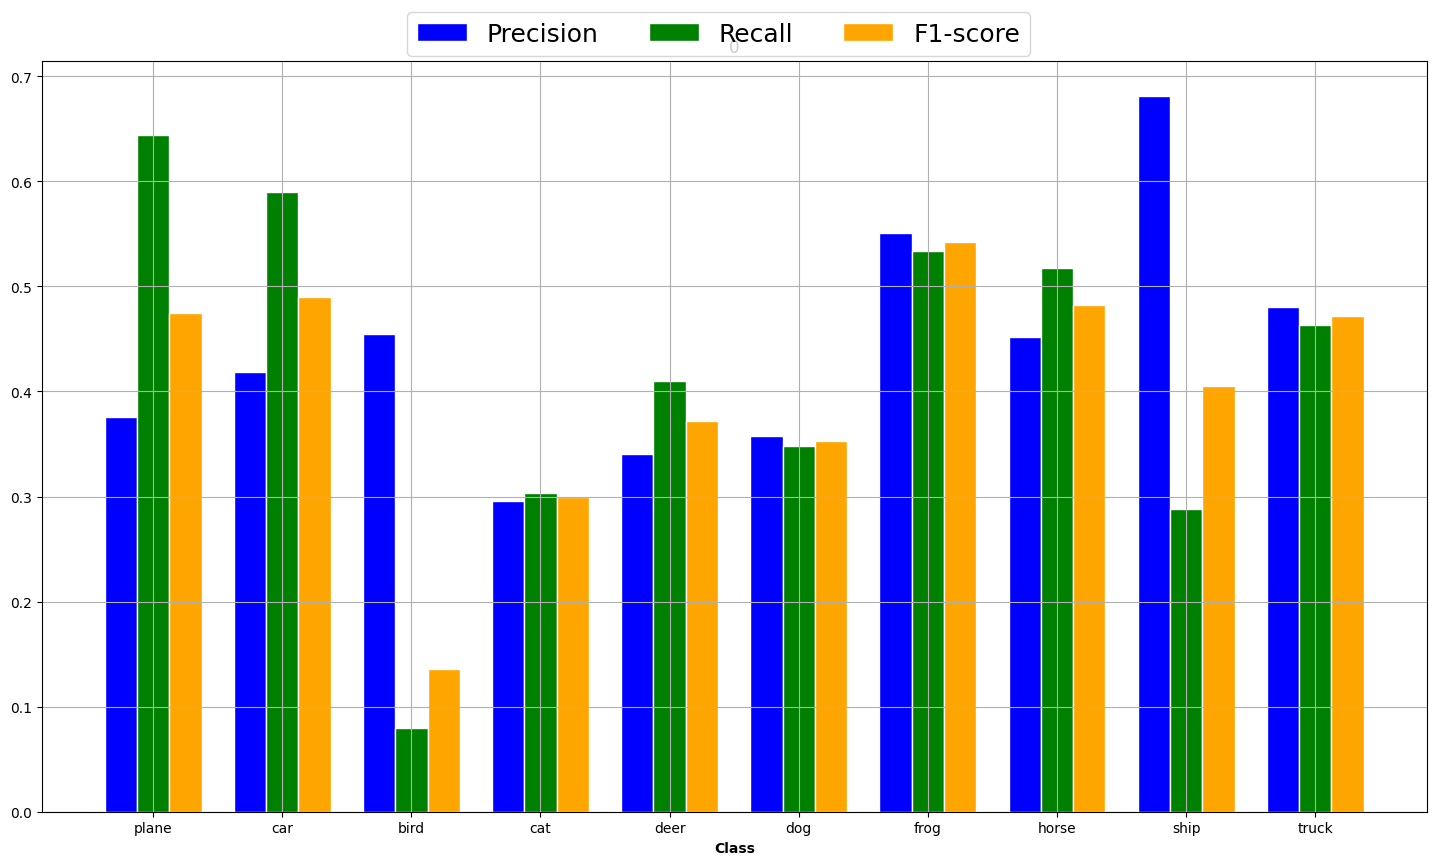

In [20]:
fig, ax = plt.subplots(len(in_features), 1, figsize=(15, 9))
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
bar_width = 0.25#         x = self.fc1(x)
i = 0
precisions = result_dict[i]['precision']
recall = result_dict[i]['recall']
f1 = result_dict[i]['f1']
r1 = np.arange(len(precisions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
ax.bar(r2, recall, color='green', width=bar_width, edgecolor='white', label='Recall')
ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
ax.set_title(str(i))
ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
ax.grid()
plt.xlabel('Class', fontweight='bold')
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
plt.tight_layout(pad=3)
plt.show()

In [21]:
accuracies = []
for choice in range(3):
    true_y, pred_y = [], []
    for i, data in enumerate(test_loader):#         x = self.fc1(x)
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        _, outs = baseline(images)
        outs, _ = simulate_exit(outs, choice=choice)
        outputs = exit_model(outs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_y = pred_y + list(predicted.detach().cpu().numpy())
        true_y = true_y + list(labels.detach().cpu().numpy())
    report = classification_report(true_y, pred_y, output_dict=True)
    accuracies.append(report["accuracy"])
    print(f'Layer: {choice+1} | Accuracy: {report["accuracy"]}')

Layer: 1 | Accuracy: 0.2917
Layer: 2 | Accuracy: 0.4378
Layer: 3 | Accuracy: 0.5187


In [22]:
# plt.figure(figsize=(15, 7))
# x = [1, 2, 3]
# plt.plot(x, accuracies, 
#          marker='o', markerfacecolor='orange', markersize=12, color='red', linewidth=4,
#          label="General EE"
#         )
# plt.plot(x, ind_accuracies, 
#          marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,
#          label="Non-general EE"
#         )
# plt.axhline(0.7067, marker='', color='olive', linewidth=4, linestyle='dashed', label="Baseline")
# plt.xlabel("Exit Layer", fontsize=24)
# plt.ylabel("Accuracy", fontsize=24)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.grid(color='k', linestyle='--', linewidth=1)
# plt.legend(loc="best", prop={'size': 18})
# plt.show()

In [23]:
accuracies

[0.2917, 0.4378, 0.5187]

In [24]:
# ind_accuracies